# Polynomial Regression

#### Imports

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [9]:
from transformers import AverageTransformer, DateTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


In [3]:
X = pd.read_csv('data/train.csv')
y = X['TARGET_energy']
X.drop(columns=['TARGET_energy', 'rv1', 'rv2'], inplace=True)
X.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,2016-02-20 13:20:00,21.530000,45.096667,20.600000,40.500000,21.474,42.40,18.323333,46.10,17.600000,...,20.650000,47.895000,17.70,44.200000,9.500000,755.000000,92.000000,5.333333,32.666667,8.200000
1,2016-01-23 06:20:00,17.290000,43.200000,16.356667,43.290000,17.700,41.20,15.300000,42.53,15.533333,...,16.655556,45.971667,15.19,42.433333,5.900000,766.866667,99.666667,4.000000,19.000000,5.833333
2,2016-04-02 09:50:00,20.890000,39.400000,18.790000,42.700000,21.790,37.40,19.790000,38.40,19.290000,...,21.200000,39.590000,19.60,37.730000,7.600000,757.983333,82.500000,1.833333,64.000000,4.716667
3,2016-02-07 12:40:00,21.133333,44.500000,20.500000,42.156667,21.500,43.59,18.790000,43.20,19.055556,...,20.890000,46.850556,19.10,44.933333,8.133333,745.966667,73.333333,8.333333,40.000000,3.533333
4,2016-04-21 19:50:00,23.000000,37.163333,22.500000,35.363333,23.200,36.40,22.890000,34.29,20.790000,...,23.000000,38.463333,20.20,35.730000,15.783333,759.516667,54.666667,4.000000,40.000000,6.566667


##### Configuration

In [4]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style='ticks', palette='viridis', rc={"axes.spines.right": False, "axes.spines.top": False})

#### Evaluation

In [5]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

rmse = make_scorer(mean_squared_error)
r2 = make_scorer(r2_score)

#### Preprocessing

In [12]:
T_cols = [col for col in X.columns if re.search('T\d', col)]
RH_cols = [col for col in X.columns if re.search('RH_[1-4,7-9]', col)]

t_at = AverageTransformer(T_cols, column_name=['T_avg'])
rh_at = AverageTransformer(RH_cols, ['RH_avg'])
pt = PowerTransformer()
pf = PolynomialFeatures(degree=2, include_bias=True)
lr = LinearRegression()

In [13]:
preprocess = make_column_transformer((t_at, T_cols), (rh_at, RH_cols), (DateTransformer(['date']), ['date']), remainder='passthrough')
pipeline = make_pipeline(preprocess, pt, pf, lr)

In [16]:
cv_scores = cross_validate(pipeline, X, y, cv=5, scoring=['neg_mean_squared_error', 'r2'], return_estimator=True)
cv_df = pd.DataFrame(cv_scores)
cv_df

,fit_time,score_time,estimator,test_neg_mean_squared_error,test_r2
0,0.787719,0.050251,"(ColumnTransformer(remainder='passthrough',\n ...",-8251.368902,0.184754
1,0.627290,0.052781,"(ColumnTransformer(remainder='passthrough',\n ...",-10121.107777,0.211821
2,0.755578,0.049329,"(ColumnTransformer(remainder='passthrough',\n ...",-8133.481907,0.212821
3,0.674926,0.053350,"(ColumnTransformer(remainder='passthrough',\n ...",-8065.957861,0.211697
4,0.666465,0.051615,"(ColumnTransformer(remainder='passthrough',\n ...",-7896.117515,0.216339


In [18]:
print(f'average real mean squared error: {abs(cv_df.iloc[:,3].mean()):.2f}')
print(f'average r squared: {abs(cv_df.iloc[:,4].mean()):.2f}')

average real mean squared error: 8493.61
average r squared: 0.21


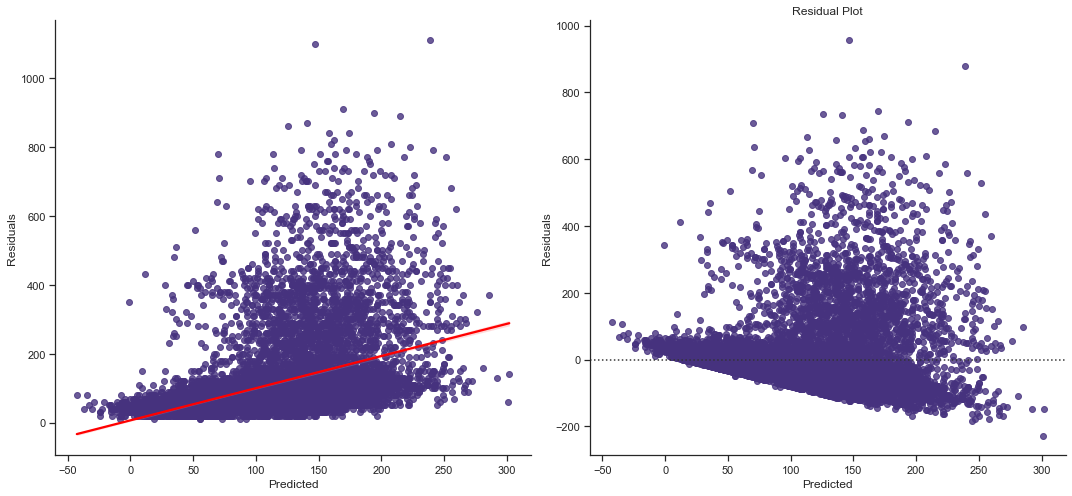

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

y_hat = cross_val_predict(pipeline, X, y, cv=5)

sns.regplot(x=y_hat, y=y, ax=ax[0], line_kws={'color':'r'})
sns.residplot(x=y_hat, y=y, ax=ax[1])

ax[1].set_title('Residual Plot')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Residuals')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()